In [1]:
import pandas as pd
df = pd.read_csv("/home/marko/projects/tf216/pv/pvfinal.csv")

In [2]:
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
for idx, col_name in enumerate(df.columns):
    print(f"Index: {idx}, Column Name: {col_name}")

Index: 0, Column Name: RHUM
Index: 1, Column Name: MAX
Index: 2, Column Name: MIN
Index: 3, Column Name: TEMP
Index: 4, Column Name: WDSP


In [3]:
ry = pd.read_csv("/home/marko/projects/tf216/pv/rypv.csv")
ry['DATE'] = pd.to_datetime(ry['DATE'])
ry = ry.set_index('DATE')
ry.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2024-01-01 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RHUM    365 non-null    float64
 1   MAX     365 non-null    float64
 2   MIN     365 non-null    float64
 3   TEMP    365 non-null    float64
 4   WDSP    365 non-null    float64
dtypes: float64(5)
memory usage: 17.1 KB


In [4]:
df_train = df["2002-01-01":"2019-12-31"]
df_valid = df["2020-01-01":"2023-12-31"]
df_test = df["2024-01-01":"2024-12-31"]

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

def split_inputs_and_targets(time_series):
    ahead = 365
    target_cols = tf.constant([1, 2, 3], dtype=tf.int32)
    X = time_series[:, :-ahead]
    Y = tf.gather(time_series[:, -ahead:], target_cols, axis=-1)
    return X, Y


seq_length = 365
train_ds = tf.keras.utils.timeseries_dataset_from_array(
	df_train.to_numpy(),
	targets=None,
	sequence_length=seq_length + 365,
	batch_size=32,
	shuffle=True,
	seed=42
).map(split_inputs_and_targets)


valid_ds = tf.keras.utils.timeseries_dataset_from_array(
	df_valid.to_numpy(),
	targets=None,
	sequence_length=seq_length + 365,
	batch_size=32,
	shuffle=False
).map(split_inputs_and_targets)

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

df_test = df_test.drop(pd.to_datetime("2024-02-29"))

X = df_valid.to_numpy()[np.newaxis, :seq_length]
Y_test = df_test.iloc[:, [1, 2, 3]].to_numpy()

Y_ref = ry.iloc[:, [1, 2, 3]].to_numpy()

mae_ref = mean_absolute_error(Y_test[:, 2], Y_ref[:, 2])
print(f'Mean Absolute Error (MAE): {mae_ref:.3f}')

rmse_ref = np.sqrt(mean_squared_error(Y_test[:, 2], Y_ref[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_ref:.3f}')

Mean Absolute Error (MAE): 4.773
Root Mean Squared Error (RMSE): 5.801


In [7]:
lstm_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_32.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_32 = lstm_32.fit(train_ds, validation_data=valid_ds, epochs=80)
lstm_32.save('models/lstm_32.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 171.0678 - mae: 10.4961 - val_loss: 114.8117 - val_mae: 8.6181
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 97.3748 - mae: 8.0428 - val_loss: 83.9915 - val_mae: 7.5910
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 78.4839 - mae: 7.3767 - val_loss: 74.7094 - val_mae: 7.2542
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 73.5442 - mae: 7.1808 - val_loss: 72.1880 - val_mae: 7.1566
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 72.4922 - mae: 7.1331 - val_loss: 71.5452 - val_mae: 7.1269
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 72.2876 - mae: 7.1187 - val_loss: 71.3803 - val_mae: 7.1182
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 72.2812 - mae: 7.1148 - val_loss: 71.3431 - val_mae: 7.1161
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 72.2926 - mae: 7.1151 - val_loss: 71.3242 - val_mae: 7.1151
Epoch 9/80
183/183 ━━━━━━━━━━

In [9]:
from tensorflow.keras.models import load_model
lstm_32 = load_model('models/lstm_32.keras')
history_lstm_32_2 = lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_32.save('models/lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 17.2756 - mae: 3.1389 - val_loss: 16.7926 - val_mae: 3.0858
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 17.2174 - mae: 3.1330 - val_loss: 16.5567 - val_mae: 3.0612
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 17.2018 - mae: 3.1319 - val_loss: 16.4986 - val_mae: 3.0575
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 17.2105 - mae: 3.1344 - val_loss: 16.3636 - val_mae: 3.0433
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 17.2077 - mae: 3.1331 - val_loss: 16.5639 - val_mae: 3.0614
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 17.1670 - mae: 3.1296 - val_loss: 16.9220 - val_mae: 3.1146
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 17.1413 - mae: 3.1263 - val_loss: 16.7860 - val_mae: 3.0889
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 17.1485 - mae: 3.1268 - val_loss: 16.4887 - val_mae: 3.0511
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [10]:
lstm_32 = tf.keras.models.load_model('models/lstm_32.keras')

Y_lstm_32 = lstm_32.predict(X)  # shape: (1, 365, 3)
Y_lstm_32 = Y_lstm_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_32_pred.csv')

mae_lstm_32 = mean_absolute_error(Y_test[:, 2], Y_lstm_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_32:.3f}')

rmse_lstm_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_32:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Mean Absolute Error (MAE): 3.587
Root Mean Squared Error (RMSE): 4.418


In [11]:
conv_lstm_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_32.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_32 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 168.8899 - mae: 10.4244 - val_loss: 119.0060 - val_mae: 8.7546
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 100.6195 - mae: 8.1546 - val_loss: 86.5410 - val_mae: 7.6808
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 80.0487 - mae: 7.4358 - val_loss: 75.7566 - val_mae: 7.2926
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 74.0007 - mae: 7.2012 - val_loss: 72.5373 - val_mae: 7.1712
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 72.5899 - mae: 7.1377 - val_loss: 71.6689 - val_mae: 7.1330
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 72.3538 - mae: 7.1226 - val_loss: 71.4212 - val_mae: 7.1203
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 72.2990 - mae: 7.1165 - val_loss: 71.3512 - val_mae: 7.1165
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 72.2675 - mae: 7.1138 - val_loss: 71.3342 - val_mae: 7.1155
Epoch 9/60
183/183 ━━━━━━━━━

In [13]:
from tensorflow.keras.models import load_model
conv_lstm_32 = load_model('models/conv_lstm_32.keras')
history_conv_lstm_32_2 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 17.0255 - mae: 3.1251 - val_loss: 16.8587 - val_mae: 3.0905
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 16.9570 - mae: 3.1171 - val_loss: 16.9397 - val_mae: 3.0939
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.9574 - mae: 3.1186 - val_loss: 16.5292 - val_mae: 3.0613
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 16.8899 - mae: 3.1102 - val_loss: 16.9040 - val_mae: 3.0938
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 16.8975 - mae: 3.1123 - val_loss: 16.7809 - val_mae: 3.0783
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 16.8588 - mae: 3.1071 - val_loss: 16.5121 - val_mae: 3.0600
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 16.8534 - mae: 3.1075 - val_loss: 16.7258 - val_mae: 3.0742
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.8152 - mae: 3.1019 - val_loss: 16.4532 - val_mae: 3.0501
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [15]:
conv_lstm_32 = load_model('models/conv_lstm_32.keras')
history_conv_lstm_32_3 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 16.7887 - mae: 3.0999 - val_loss: 16.5094 - val_mae: 3.0495
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.7169 - mae: 3.0913 - val_loss: 16.4162 - val_mae: 3.0566
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 16.7580 - mae: 3.0965 - val_loss: 16.4984 - val_mae: 3.0614
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.7080 - mae: 3.0913 - val_loss: 16.2426 - val_mae: 3.0311
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.7232 - mae: 3.0925 - val_loss: 16.3267 - val_mae: 3.0537
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.7279 - mae: 3.0937 - val_loss: 16.4680 - val_mae: 3.0586
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.6498 - mae: 3.0842 - val_loss: 16.4926 - val_mae: 3.0653
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 16.6772 - mae: 3.0878 - val_loss: 16.2951 - val_mae: 3.0311
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [17]:
conv_lstm_32 = load_model('models/conv_lstm_32.keras')
history_conv_lstm_32_4 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 16.6229 - mae: 3.0817 - val_loss: 16.4559 - val_mae: 3.0664
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.6142 - mae: 3.0820 - val_loss: 16.3434 - val_mae: 3.0486
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.6190 - mae: 3.0829 - val_loss: 16.2963 - val_mae: 3.0480
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 16.5907 - mae: 3.0800 - val_loss: 16.2322 - val_mae: 3.0492
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 16.5559 - mae: 3.0754 - val_loss: 16.2573 - val_mae: 3.0514
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.5433 - mae: 3.0740 - val_loss: 16.3558 - val_mae: 3.0641
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.5227 - mae: 3.0717 - val_loss: 16.2365 - val_mae: 3.0391
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 16.5237 - mae: 3.0723 - val_loss: 16.2624 - val_mae: 3.0508
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [19]:
conv_lstm_32 = load_model('models/conv_lstm_32.keras')
history_conv_lstm_32_5 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 16.4993 - mae: 3.0698 - val_loss: 16.4159 - val_mae: 3.0500
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.4390 - mae: 3.0632 - val_loss: 16.3597 - val_mae: 3.0474
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.4602 - mae: 3.0661 - val_loss: 16.2452 - val_mae: 3.0394
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 16.4610 - mae: 3.0666 - val_loss: 16.0876 - val_mae: 3.0296
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.4632 - mae: 3.0659 - val_loss: 16.0378 - val_mae: 3.0256
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 16.4294 - mae: 3.0627 - val_loss: 16.2600 - val_mae: 3.0411
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.4492 - mae: 3.0661 - val_loss: 16.3988 - val_mae: 3.0544
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 16.3932 - mae: 3.0586 - val_loss: 16.4712 - val_mae: 3.0543
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [20]:
conv_lstm_32 = tf.keras.models.load_model('models/conv_lstm_32.keras')

Y_conv_lstm_32 = conv_lstm_32.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_32 = Y_conv_lstm_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_32_pred.csv')

mae_conv_lstm_32 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_32:.3f}')

rmse_conv_lstm_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_32:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Mean Absolute Error (MAE): 3.805
Root Mean Squared Error (RMSE): 4.680


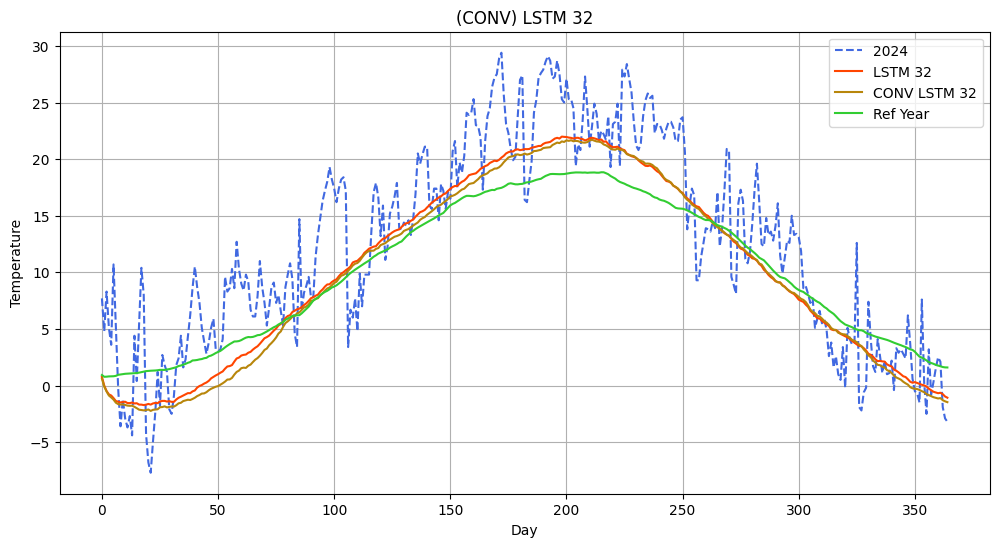

In [21]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_32[:, 2], label="LSTM 32", color='orangered')
plt.plot(x, Y_conv_lstm_32[:, 2], label="CONV LSTM 32", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 32")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [22]:
lstm_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_64.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_64 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_64.save('models/lstm_64.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 153.7346 - mae: 9.9066 - val_loss: 81.1556 - val_mae: 7.4062
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 71.9604 - mae: 7.0204 - val_loss: 62.4956 - val_mae: 6.6072
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 61.4759 - mae: 6.5075 - val_loss: 57.0723 - val_mae: 6.2959
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 57.2553 - mae: 6.2496 - val_loss: 52.9177 - val_mae: 6.0414
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 53.3174 - mae: 6.0054 - val_loss: 49.0179 - val_mae: 5.7876
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 49.7612 - mae: 5.7767 - val_loss: 45.2436 - val_mae: 5.5329
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 45.9257 - mae: 5.5196 - val_loss: 41.8088 - val_mae: 5.2921
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 42.6673 - mae: 5.2925 - val_loss: 38.3255 - val_mae: 5.0370
Epoch 9/60
183/183 ━━━━━━━━━━━━

In [24]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_2 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_64.save('models/lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 17.3624 - mae: 3.1456 - val_loss: 15.9105 - val_mae: 3.0099
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 17.3377 - mae: 3.1444 - val_loss: 16.5095 - val_mae: 3.0598
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 17.3339 - mae: 3.1435 - val_loss: 16.5442 - val_mae: 3.0813
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 17.3084 - mae: 3.1405 - val_loss: 17.0443 - val_mae: 3.1352
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 17.2949 - mae: 3.1398 - val_loss: 16.5639 - val_mae: 3.0702
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 17.2610 - mae: 3.1380 - val_loss: 16.4490 - val_mae: 3.0595
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 17.2314 - mae: 3.1340 - val_loss: 16.7877 - val_mae: 3.1078
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 17.2716 - mae: 3.1391 - val_loss: 16.6574 - val_mae: 3.0804
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [25]:
lstm_64 = tf.keras.models.load_model('models/lstm_64.keras')

Y_lstm_64 = lstm_64.predict(X)  # shape: (1, 365, 3)
Y_lstm_64 = Y_lstm_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_64_pred.csv')

mae_lstm_64 = mean_absolute_error(Y_test[:, 2], Y_lstm_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_64:.3f}')

rmse_lstm_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Mean Absolute Error (MAE): 3.578
Root Mean Squared Error (RMSE): 4.395


In [26]:
conv_lstm_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_64.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_64 = conv_lstm_64.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_64.save('models/conv_lstm_64.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 151.8595 - mae: 9.8465 - val_loss: 83.9925 - val_mae: 7.5257
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 74.2509 - mae: 7.1338 - val_loss: 64.9781 - val_mae: 6.7466
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 64.0630 - mae: 6.6587 - val_loss: 60.2022 - val_mae: 6.4862
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 60.4755 - mae: 6.4467 - val_loss: 56.9459 - val_mae: 6.2927
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 57.3703 - mae: 6.2593 - val_loss: 54.2209 - val_mae: 6.1237
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 54.5067 - mae: 6.0813 - val_loss: 50.7866 - val_mae: 5.9049
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 51.5029 - mae: 5.8932 - val_loss: 47.7427 - val_mae: 5.7011
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 48.4024 - mae: 5.6892 - val_loss: 44.5849 - val_mae: 5.4865
Epoch 9/60
183/183 ━━━━━━━━━━━━

In [27]:
conv_lstm_64 = tf.keras.models.load_model('models/conv_lstm_64.keras')

Y_conv_lstm_64 = conv_lstm_64.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_64 = Y_conv_lstm_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_64_pred.csv')

mae_conv_lstm_64 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_64:.3f}')

rmse_conv_lstm_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Mean Absolute Error (MAE): 3.655
Root Mean Squared Error (RMSE): 4.481


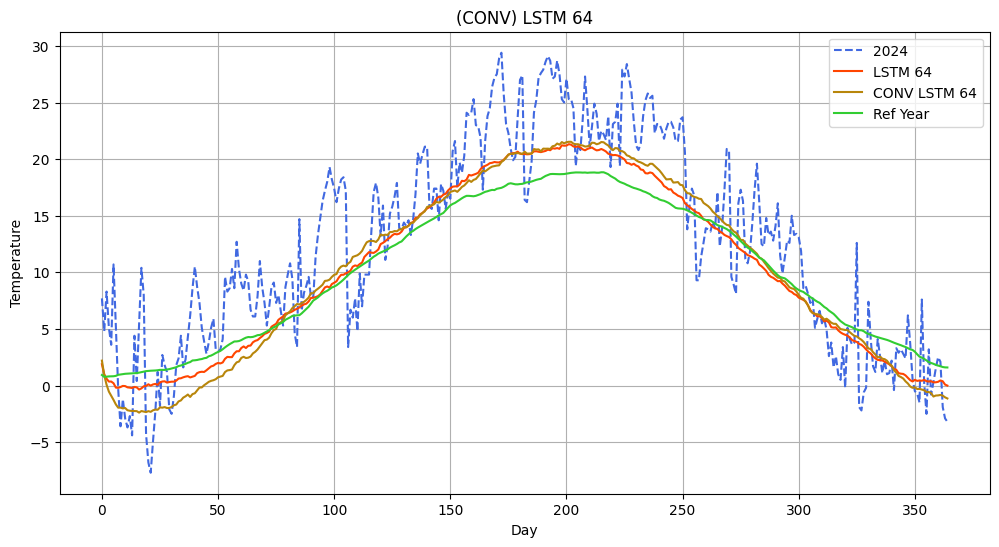

In [28]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_64[:, 2], label="LSTM 64", color='orangered')
plt.plot(x, Y_conv_lstm_64[:, 2], label="CONV LSTM 64", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 64")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [35]:
lstm_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_128 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=40)
lstm_128.save('models/lstm_128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 130.9572 - mae: 9.1366 - val_loss: 69.1788 - val_mae: 6.9924
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 68.9121 - mae: 6.9305 - val_loss: 65.8748 - val_mae: 6.8125
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 66.2814 - mae: 6.7813 - val_loss: 63.3791 - val_mae: 6.6696
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 63.7688 - mae: 6.6360 - val_loss: 60.2339 - val_mae: 6.4845
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 60.3936 - mae: 6.4343 - val_loss: 55.5887 - val_mae: 6.1986
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 55.7949 - mae: 6.1489 - val_loss: 50.9158 - val_mae: 5.8931
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 51.0994 - mae: 5.8467 - val_loss: 46.2172 - val_mae: 5.5762
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 46.8197 - mae: 5.5597 - val_loss: 42.5130 - val_mae: 5.2992
Epoch 9/40
183/183 ━━━━━━━━━━━━

In [36]:
lstm_128 = tf.keras.models.load_model('models/lstm_128.keras')

Y_lstm_128 = lstm_128.predict(X)  # shape: (1, 365, 3)
Y_lstm_128 = Y_lstm_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_128_pred.csv')

mae_lstm_128 = mean_absolute_error(Y_test[:, 2], Y_lstm_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_128:.3f}')

rmse_lstm_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Mean Absolute Error (MAE): 3.793
Root Mean Squared Error (RMSE): 4.639


In [46]:
conv_lstm_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_128 = conv_lstm_128.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_lstm_128.save('models/conv_lstm_128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 130.9042 - mae: 9.1307 - val_loss: 68.2191 - val_mae: 6.9354
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 67.4837 - mae: 6.8513 - val_loss: 63.7188 - val_mae: 6.6897
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 64.0886 - mae: 6.6530 - val_loss: 60.6837 - val_mae: 6.5093
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 60.8631 - mae: 6.4634 - val_loss: 57.0708 - val_mae: 6.2879
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 57.3485 - mae: 6.2465 - val_loss: 53.5250 - val_mae: 6.0622
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 53.7485 - mae: 6.0182 - val_loss: 48.8279 - val_mae: 5.7570
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 49.3376 - mae: 5.7315 - val_loss: 43.5672 - val_mae: 5.3948
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 43.9332 - mae: 5.3621 - val_loss: 37.4939 - val_mae: 4.9520
Epoch 9/40
183/183 ━━━━━━━━━━━━

In [48]:
from tensorflow.keras.models import load_model
conv_lstm_128 = load_model('models/conv_lstm_128.keras')
history_conv_lstm_128_2 = conv_lstm_128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_128.save('models/conv_lstm_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 16.5082 - mae: 3.0660 - val_loss: 15.9901 - val_mae: 3.0156
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 16.4397 - mae: 3.0599 - val_loss: 16.1584 - val_mae: 3.0427
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 16.4595 - mae: 3.0627 - val_loss: 15.8518 - val_mae: 2.9965
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 16.4353 - mae: 3.0624 - val_loss: 15.8487 - val_mae: 2.9938
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 16.3950 - mae: 3.0564 - val_loss: 15.9176 - val_mae: 2.9992
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 16.3384 - mae: 3.0496 - val_loss: 15.9355 - val_mae: 3.0213
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 16.3429 - mae: 3.0524 - val_loss: 15.8354 - val_mae: 2.9998
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 16.3241 - mae: 3.0500 - val_loss: 15.8630 - val_mae: 3.0061
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [49]:
conv_lstm_128 = tf.keras.models.load_model('models/conv_lstm_128.keras')

Y_conv_lstm_128 = conv_lstm_128.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_128 = Y_conv_lstm_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_128_pred.csv')

mae_conv_lstm_128 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_128:.3f}')

rmse_conv_lstm_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Mean Absolute Error (MAE): 3.911
Root Mean Squared Error (RMSE): 4.773


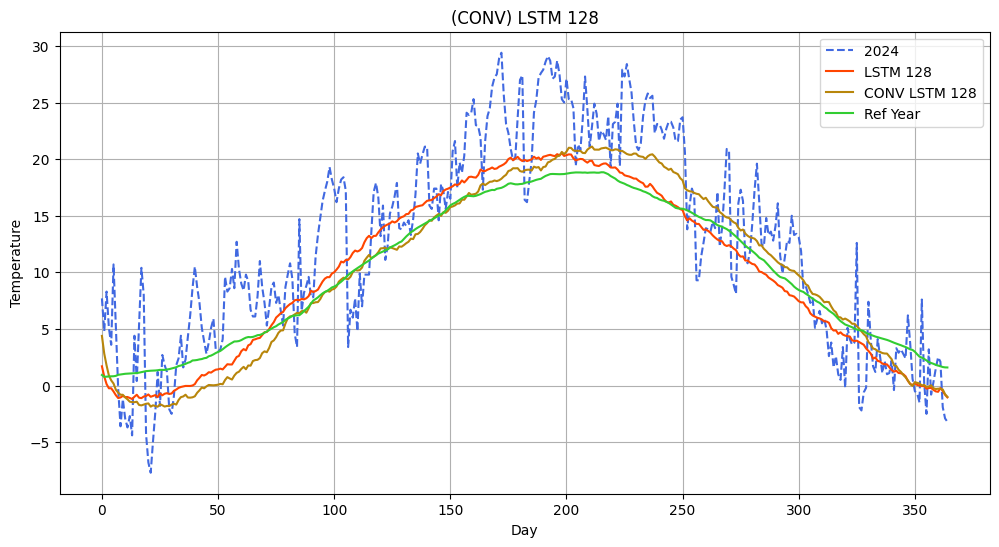

In [50]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_128[:, 2], label="LSTM 128", color='orangered')
plt.plot(x, Y_conv_lstm_128[:, 2], label="CONV LSTM 128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [51]:
lstm_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_3232 = lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_3232.save('models/lstm_3232.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 169.2807 - mae: 10.4353 - val_loss: 117.7041 - val_mae: 8.7121
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 99.6302 - mae: 8.1196 - val_loss: 85.7503 - val_mae: 7.6528
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 79.6013 - mae: 7.4187 - val_loss: 75.4152 - val_mae: 7.2802
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 73.8727 - mae: 7.1956 - val_loss: 72.4160 - val_mae: 7.1662
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 72.5468 - mae: 7.1348 - val_loss: 71.6197 - val_mae: 7.1307
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 72.3124 - mae: 7.1192 - val_loss: 71.4093 - val_mae: 7.1196
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 72.3430 - mae: 7.1190 - val_loss: 71.3467 - val_mae: 7.1163
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 72.3396 - mae: 7.1185 - val_loss: 71.3345 - val_mae: 7.1156
Epoch 9/60
183/183 ━━━━━━━━━

In [52]:
from tensorflow.keras.models import load_model
lstm_3232 = load_model('models/lstm_3232.keras')
history_lstm_3232_2 = lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_3232.save('models/lstm_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 18.0019 - mae: 3.2193 - val_loss: 15.6857 - val_mae: 3.0089
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 17.9780 - mae: 3.2168 - val_loss: 15.7265 - val_mae: 3.0142
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 17.9613 - mae: 3.2146 - val_loss: 15.6778 - val_mae: 3.0083
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 17.7873 - mae: 3.1951 - val_loss: 15.7249 - val_mae: 3.0107
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 17.7709 - mae: 3.1927 - val_loss: 15.5871 - val_mae: 2.9840
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 17.7030 - mae: 3.1843 - val_loss: 15.5566 - val_mae: 2.9868
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 17.7104 - mae: 3.1866 - val_loss: 15.5618 - val_mae: 2.9916
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 17.6918 - mae: 3.1844 - val_loss: 15.4798 - val_mae: 2.9772
Epoch 9/10
183/183 ━━━━━━━━━━━

In [7]:
from tensorflow.keras.models import load_model
lstm_3232 = load_model('models/lstm_3232.keras')
history_lstm_3232_3 = lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_3232.save('models/lstm_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 17.5870 - mae: 3.1734 - val_loss: 15.3367 - val_mae: 2.9578
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 17.5620 - mae: 3.1711 - val_loss: 15.2533 - val_mae: 2.9450
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 17.5086 - mae: 3.1649 - val_loss: 15.2744 - val_mae: 2.9516
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 17.4335 - mae: 3.1591 - val_loss: 15.1210 - val_mae: 2.9328
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 17.3825 - mae: 3.1547 - val_loss: 15.2301 - val_mae: 2.9534
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 17.3663 - mae: 3.1540 - val_loss: 15.0453 - val_mae: 2.9241
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 17.3107 - mae: 3.1495 - val_loss: 15.2533 - val_mae: 2.9516
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 17.2872 - mae: 3.1482 - val_loss: 15.0775 - val_mae: 2.9344
Epoch 9/10
183/183 ━━━━━━━━━

In [8]:
lstm_3232 = tf.keras.models.load_model('models/lstm_3232.keras')

Y_lstm_3232 = lstm_3232.predict(X)  # shape: (1, 365, 3)
Y_lstm_3232 = Y_lstm_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_3232_pred.csv')

mae_lstm_3232 = mean_absolute_error(Y_test[:, 2], Y_lstm_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_3232:.3f}')

rmse_lstm_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
Mean Absolute Error (MAE): 3.718
Root Mean Squared Error (RMSE): 4.547


In [54]:
conv_lstm_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_3232.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_3232 = conv_lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_3232.save('models/conv_lstm_3232.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 169.3397 - mae: 10.4375 - val_loss: 118.5654 - val_mae: 8.7404
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 100.2226 - mae: 8.1417 - val_loss: 86.1898 - val_mae: 7.6685
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 79.8675 - mae: 7.4279 - val_loss: 75.5939 - val_mae: 7.2868
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 73.9787 - mae: 7.2006 - val_loss: 72.4818 - val_mae: 7.1689
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 72.5114 - mae: 7.1341 - val_loss: 71.6364 - val_mae: 7.1315
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 72.3695 - mae: 7.1233 - val_loss: 71.4143 - val_mae: 7.1198
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 72.2156 - mae: 7.1128 - val_loss: 71.3542 - val_mae: 7.1167
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 72.3182 - mae: 7.1166 - val_loss: 71.3374 - val_mae: 7.1158
Epoch 9/60
183/183 ━━━━━━━━━

In [55]:
conv_lstm_3232 = tf.keras.models.load_model('models/conv_lstm_3232.keras')

Y_conv_lstm_3232 = conv_lstm_3232.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_3232 = Y_conv_lstm_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_3232_pred.csv')

mae_conv_lstm_3232 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_3232:.3f}')

rmse_conv_lstm_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Mean Absolute Error (MAE): 3.696
Root Mean Squared Error (RMSE): 4.529


In [9]:
conv_lstm_3232 = tf.keras.models.load_model('models/conv_lstm_3232.keras')

Y_conv_lstm_3232 = conv_lstm_3232.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_3232 = Y_conv_lstm_3232[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


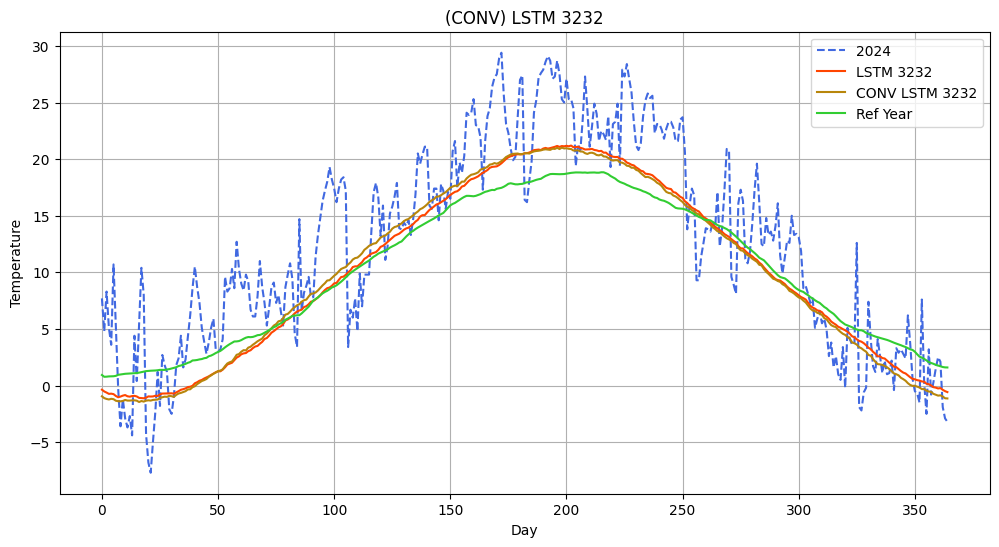

In [10]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_3232[:, 2], label="LSTM 3232", color='orangered')
plt.plot(x, Y_conv_lstm_3232[:, 2], label="CONV LSTM 3232", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [57]:
lstm_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_6464 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=40)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 151.9946 - mae: 9.8588 - val_loss: 85.4118 - val_mae: 7.6411
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 77.9128 - mae: 7.3527 - val_loss: 72.3974 - val_mae: 7.1656
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 72.4822 - mae: 7.1309 - val_loss: 71.4216 - val_mae: 7.1202
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 72.3010 - mae: 7.1168 - val_loss: 71.3982 - val_mae: 7.1186
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 72.2774 - mae: 7.1150 - val_loss: 71.3414 - val_mae: 7.1159
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 72.3669 - mae: 7.1197 - val_loss: 71.3501 - val_mae: 7.1163
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 72.3056 - mae: 7.1161 - val_loss: 71.3631 - val_mae: 7.1168
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 72.2952 - mae: 7.1149 - val_loss: 71.3588 - val_mae: 7.1168
Epoch 9/40
183/183 ━━━━━━━━━

In [58]:
from tensorflow.keras.models import load_model
lstm_6464 = load_model('models/lstm_6464.keras')
history_lstm_6464_2 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 17.7579 - mae: 3.1945 - val_loss: 15.1854 - val_mae: 2.9406
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 17.6054 - mae: 3.1787 - val_loss: 15.4309 - val_mae: 2.9678
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 17.5079 - mae: 3.1683 - val_loss: 15.1995 - val_mae: 2.9403
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 17.3286 - mae: 3.1528 - val_loss: 15.3008 - val_mae: 2.9522
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 17.2170 - mae: 3.1410 - val_loss: 15.7341 - val_mae: 2.9960
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 17.0706 - mae: 3.1260 - val_loss: 15.3495 - val_mae: 2.9515
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 16.9899 - mae: 3.1177 - val_loss: 15.4028 - val_mae: 2.9561
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 16.9559 - mae: 3.1149 - val_loss: 15.2179 - val_mae: 2.9316
Epoch 9/10
183/183 ━━━━━━━━━━

In [60]:
from tensorflow.keras.models import load_model
lstm_6464 = load_model('models/lstm_6464.keras')
history_lstm_6464_3 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 16.7583 - mae: 3.0954 - val_loss: 15.2049 - val_mae: 2.9230
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 16.6964 - mae: 3.0892 - val_loss: 15.4185 - val_mae: 2.9491
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 16.6489 - mae: 3.0841 - val_loss: 15.4089 - val_mae: 2.9394
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 16.6112 - mae: 3.0796 - val_loss: 15.6016 - val_mae: 2.9585
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 16.5737 - mae: 3.0763 - val_loss: 15.5526 - val_mae: 2.9632
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 16.5278 - mae: 3.0712 - val_loss: 15.6624 - val_mae: 2.9731
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 16.5198 - mae: 3.0713 - val_loss: 15.6592 - val_mae: 2.9644
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 16.4669 - mae: 3.0643 - val_loss: 15.9271 - val_mae: 2.9983
Epoch 9/10
183/183 ━━━━━━━━━━━━

In [61]:
lstm_6464 = tf.keras.models.load_model('models/lstm_6464.keras')

Y_lstm_6464 = lstm_6464.predict(X)  # shape: (1, 365, 3)
Y_lstm_6464 = Y_lstm_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_6464_pred.csv')

mae_lstm_6464 = mean_absolute_error(Y_test[:, 2], Y_lstm_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_6464:.3f}')

rmse_lstm_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
Mean Absolute Error (MAE): 3.895
Root Mean Squared Error (RMSE): 4.751


In [69]:
conv_lstm_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_6464.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_6464 = conv_lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_lstm_6464.save('models/conv_lstm_6464.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 152.0658 - mae: 9.8607 - val_loss: 85.1171 - val_mae: 7.6081
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 76.6974 - mae: 7.2781 - val_loss: 69.6923 - val_mae: 7.0150
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 69.3635 - mae: 6.9594 - val_loss: 67.2766 - val_mae: 6.8921
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 67.9836 - mae: 6.8772 - val_loss: 65.9801 - val_mae: 6.8195
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 66.7014 - mae: 6.8047 - val_loss: 64.7308 - val_mae: 6.7497
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 65.5210 - mae: 6.7370 - val_loss: 63.7057 - val_mae: 6.6888
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 64.5213 - mae: 6.6797 - val_loss: 62.6081 - val_mae: 6.6266
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 63.5226 - mae: 6.6206 - val_loss: 61.7227 - val_mae: 6.5722
Epoch 9/40
183/183 ━━━━━━━━━━━━

In [70]:
conv_lstm_6464 = tf.keras.models.load_model('models/conv_lstm_6464.keras')

Y_conv_lstm_6464 = conv_lstm_6464.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_6464 = Y_conv_lstm_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_6464_pred.csv')

mae_conv_lstm_6464 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_6464:.3f}')

rmse_conv_lstm_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Mean Absolute Error (MAE): 3.519
Root Mean Squared Error (RMSE): 4.308


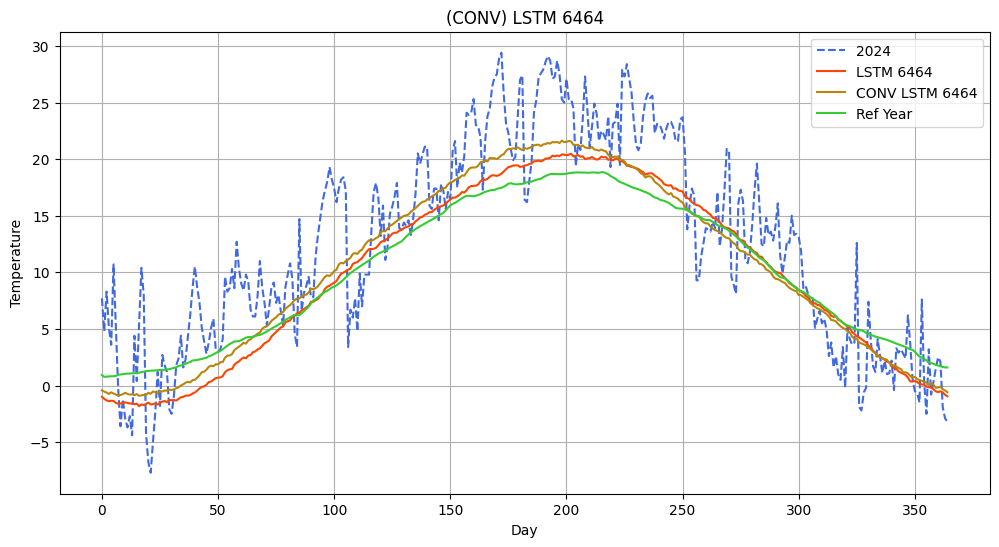

In [71]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_6464[:, 2], label="LSTM 6464", color='orangered')
plt.plot(x, Y_conv_lstm_6464[:, 2], label="CONV LSTM 6464", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [74]:
lstm_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_128128 = lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=40)
lstm_128128.save('models/lstm_128128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 131.2534 - mae: 9.1526 - val_loss: 70.7631 - val_mae: 7.0791
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 70.8013 - mae: 7.0369 - val_loss: 68.6042 - val_mae: 6.9653
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 69.2193 - mae: 6.9456 - val_loss: 67.2842 - val_mae: 6.8928
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 67.9216 - mae: 6.8735 - val_loss: 65.4243 - val_mae: 6.7841
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 65.8166 - mae: 6.7523 - val_loss: 63.1007 - val_mae: 6.6500
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 63.4227 - mae: 6.6136 - val_loss: 60.1308 - val_mae: 6.4725
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 60.2712 - mae: 6.4228 - val_loss: 55.5426 - val_mae: 6.1850
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 55.9545 - mae: 6.1495 - val_loss: 51.9877 - val_mae: 5.9346
Epoch 9/40
183/183 ━━━━

In [75]:
lstm_128128 = tf.keras.models.load_model('models/lstm_128128.keras')

Y_lstm_128128 = lstm_128128.predict(X)  # shape: (1, 365, 3)
Y_lstm_128128 = Y_lstm_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_128128_pred.csv')

mae_lstm_128128 = mean_absolute_error(Y_test[:, 2], Y_lstm_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_128128:.3f}')

rmse_lstm_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Mean Absolute Error (MAE): 3.716
Root Mean Squared Error (RMSE): 4.510


In [76]:
conv_lstm_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_128128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_128128 = conv_lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=30)
conv_lstm_128128.save('models/conv_lstm_128128.keras')

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 131.3031 - mae: 9.1607 - val_loss: 72.1552 - val_mae: 7.1552
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 72.3884 - mae: 7.1239 - val_loss: 71.4430 - val_mae: 7.1203
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 72.3575 - mae: 7.1188 - val_loss: 71.4022 - val_mae: 7.1182
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 72.4315 - mae: 7.1216 - val_loss: 71.3973 - val_mae: 7.1180
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 72.4256 - mae: 7.1201 - val_loss: 71.4300 - val_mae: 7.1194
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 72.4579 - mae: 7.1225 - val_loss: 71.4921 - val_mae: 7.1218
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 72.4938 - mae: 7.1252 - val_loss: 71.4633 - val_mae: 7.1207
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 72.3916 - mae: 7.1210 - val_loss: 71.4711 - val_mae: 7.1213
Epoch 9/30
183/183 ━━━━━━━━━━━━

In [78]:
from tensorflow.keras.models import load_model
conv_lstm_128128 = load_model('models/conv_lstm_128128.keras')
history_conv_lstm_128128_2 = conv_lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_128128.save('models/conv_lstm_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 17.0134 - mae: 3.1169 - val_loss: 15.8361 - val_mae: 3.0089
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 16.9545 - mae: 3.1114 - val_loss: 16.8774 - val_mae: 3.1291
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 16.8425 - mae: 3.1004 - val_loss: 16.6454 - val_mae: 3.0897
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 16.7284 - mae: 3.0884 - val_loss: 16.7556 - val_mae: 3.1079
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 16.7330 - mae: 3.0885 - val_loss: 16.5204 - val_mae: 3.0689
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 16.6367 - mae: 3.0778 - val_loss: 16.7615 - val_mae: 3.1083
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 16.6051 - mae: 3.0759 - val_loss: 16.7295 - val_mae: 3.0962
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 16.5786 - mae: 3.0740 - val_loss: 16.6260 - val_mae: 3.0806
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [79]:
conv_lstm_128128 = tf.keras.models.load_model('models/conv_lstm_128128.keras')

Y_conv_lstm_128128 = conv_lstm_128128.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_128128 = Y_conv_lstm_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_128128_pred.csv')

mae_conv_lstm_128128 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_128128:.3f}')

rmse_conv_lstm_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Mean Absolute Error (MAE): 3.789
Root Mean Squared Error (RMSE): 4.619


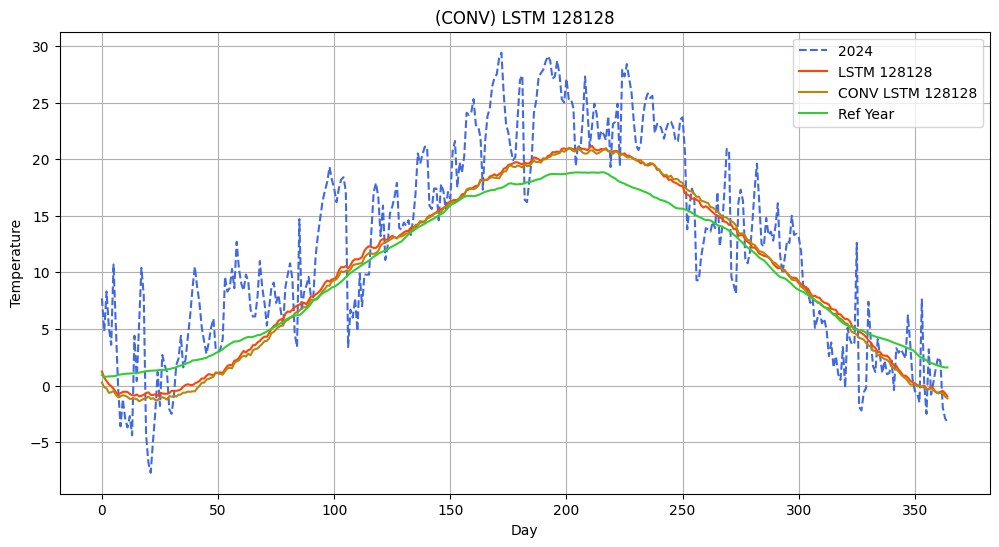

In [80]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_128128[:, 2], label="LSTM 128128", color='orangered')
plt.plot(x, Y_conv_lstm_128128[:, 2], label="CONV LSTM 128128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [81]:
gru_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_32.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_32 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=80)
gru_32.save('models/gru_32.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 170.8165 - mae: 10.4877 - val_loss: 121.7502 - val_mae: 8.8316
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 101.9763 - mae: 8.1801 - val_loss: 86.1292 - val_mae: 7.6264
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 78.5344 - mae: 7.3342 - val_loss: 72.7523 - val_mae: 7.1154
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 70.4006 - mae: 6.9962 - val_loss: 67.6645 - val_mae: 6.8973
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 67.3481 - mae: 6.8448 - val_loss: 65.3357 - val_mae: 6.7796
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 65.8271 - mae: 6.7580 - val_loss: 63.8612 - val_mae: 6.6981
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 64.5550 - mae: 6.6834 - val_loss: 62.6900 - val_mae: 6.6304
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 63.5376 - mae: 6.6213 - val_loss: 61.6358 - val_mae: 6.5685
Epoch 9/80
183/183 ━━━━━━━━━

In [82]:
gru_32 = tf.keras.models.load_model('models/gru_32.keras')

Y_gru_32 = gru_32.predict(X)  # shape: (1, 365, 3)
Y_gru_32 = Y_gru_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_32_pred.csv')

mae_gru_32 = mean_absolute_error(Y_test[:, 2], Y_gru_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_32:.3f}')

rmse_gru_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_32:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Mean Absolute Error (MAE): 3.671
Root Mean Squared Error (RMSE): 4.481


In [91]:
conv_gru_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_32.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_32 = conv_gru_32.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_gru_32.save('models/conv_gru_32.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 169.0262 - mae: 10.4294 - val_loss: 124.3963 - val_mae: 8.9279
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 104.6609 - mae: 8.2925 - val_loss: 89.6002 - val_mae: 7.7883
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 81.9399 - mae: 7.5057 - val_loss: 77.0395 - val_mae: 7.3391
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 74.6741 - mae: 7.2301 - val_loss: 72.9869 - val_mae: 7.1890
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 72.7495 - mae: 7.1452 - val_loss: 71.8042 - val_mae: 7.1395
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 72.3107 - mae: 7.1215 - val_loss: 71.4616 - val_mae: 7.1224
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 72.3210 - mae: 7.1186 - val_loss: 71.3746 - val_mae: 7.1176
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 72.3013 - mae: 7.1162 - val_loss: 71.3636 - val_mae: 7.1170
Epoch 9/40
183/183 ━━━━━━━━━

In [11]:
from tensorflow.keras.models import load_model
conv_gru_32 = load_model('models/conv_gru_32.keras')
history_conv_gru_32_2 = conv_gru_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_32.save('models/conv_gru_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 17.2142 - mae: 3.1390 - val_loss: 16.0505 - val_mae: 3.0516
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 17.1944 - mae: 3.1373 - val_loss: 15.9914 - val_mae: 3.0430
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 17.1416 - mae: 3.1327 - val_loss: 15.0792 - val_mae: 2.9333
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 17.0773 - mae: 3.1250 - val_loss: 15.1622 - val_mae: 2.9422
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 17.0637 - mae: 3.1254 - val_loss: 15.8061 - val_mae: 3.0191
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 17.0243 - mae: 3.1207 - val_loss: 15.3133 - val_mae: 2.9613
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 16.9651 - mae: 3.1146 - val_loss: 15.6354 - val_mae: 2.9919
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 16.9259 - mae: 3.1112 - val_loss: 15.4970 - val_mae: 2.9794
Epoch 9/10
183/183 ━━━━━━━━━━━━━━

In [12]:
conv_gru_32 = tf.keras.models.load_model('models/conv_gru_32.keras')

Y_conv_gru_32 = conv_gru_32.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_32 = Y_conv_gru_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_32_pred.csv')

mae_conv_gru_32 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_32:.3f}')

rmse_conv_gru_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_32:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Mean Absolute Error (MAE): 3.669
Root Mean Squared Error (RMSE): 4.501


In [13]:
gru_32 = tf.keras.models.load_model('models/gru_32.keras')

Y_gru_32 = gru_32.predict(X)  # shape: (1, 365, 3)
Y_gru_32 = Y_gru_32[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


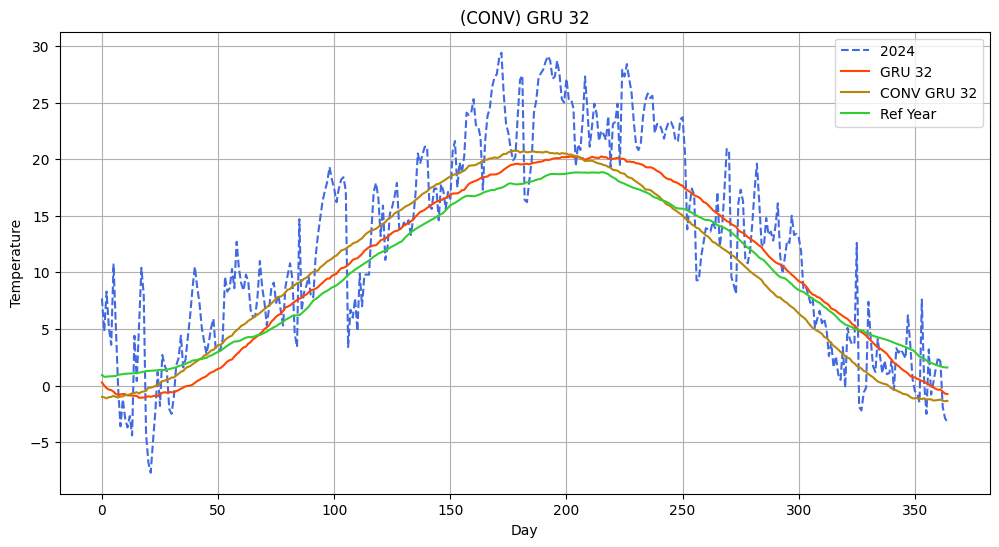

In [14]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_32[:, 2], label="GRU 32", color='orangered')
plt.plot(x, Y_conv_gru_32[:, 2], label="CONV GRU 32", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 32")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [96]:
gru_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_64.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_64 = gru_64.fit(train_ds, validation_data=valid_ds, epochs=40)
gru_64.save('models/gru_64.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 152.7789 - mae: 9.8869 - val_loss: 87.3806 - val_mae: 7.7100
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 78.7966 - mae: 7.3867 - val_loss: 72.6658 - val_mae: 7.1762
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 72.5770 - mae: 7.1377 - val_loss: 71.0945 - val_mae: 7.0973
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 71.2381 - mae: 7.0560 - val_loss: 68.7613 - val_mae: 6.9688
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 69.3979 - mae: 6.9501 - val_loss: 67.1699 - val_mae: 6.8801
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 67.8625 - mae: 6.8628 - val_loss: 65.7429 - val_mae: 6.8010
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 66.5625 - mae: 6.7896 - val_loss: 64.4291 - val_mae: 6.7265
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 65.2532 - mae: 6.7153 - val_loss: 62.9691 - val_mae: 6.6364
Epoch 9/40
183/183 ━━━━━━━━━━━━

In [97]:
gru_64 = tf.keras.models.load_model('models/gru_64.keras')

Y_gru_64 = gru_64.predict(X)  # shape: (1, 365, 3)
Y_gru_64 = Y_gru_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_64_pred.csv')

mae_gru_64 = mean_absolute_error(Y_test[:, 2], Y_gru_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_64:.3f}')

rmse_gru_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Mean Absolute Error (MAE): 3.669
Root Mean Squared Error (RMSE): 4.466


In [104]:
conv_gru_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_64.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_64 = conv_gru_64.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_gru_64.save('models/conv_gru_64.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 152.1059 - mae: 9.8639 - val_loss: 88.7500 - val_mae: 7.7580
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 79.5529 - mae: 7.4152 - val_loss: 72.8983 - val_mae: 7.1856
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 72.6471 - mae: 7.1396 - val_loss: 71.4736 - val_mae: 7.1229
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 72.3277 - mae: 7.1185 - val_loss: 71.3640 - val_mae: 7.1169
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 72.3664 - mae: 7.1180 - val_loss: 71.3670 - val_mae: 7.1171
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 72.3933 - mae: 7.1198 - val_loss: 71.3266 - val_mae: 7.1153
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 72.3013 - mae: 7.1169 - val_loss: 71.3507 - val_mae: 7.1160
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 72.3487 - mae: 7.1182 - val_loss: 71.3540 - val_mae: 7.1167
Epoch 9/40
183/183 ━━━━━━━━━━━━

In [105]:
conv_gru_64 = tf.keras.models.load_model('models/conv_gru_64.keras')

Y_conv_gru_64 = conv_gru_64.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_64 = Y_conv_gru_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_64_pred.csv')

mae_conv_gru_64 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_64:.3f}')

rmse_conv_gru_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Mean Absolute Error (MAE): 3.822
Root Mean Squared Error (RMSE): 4.695


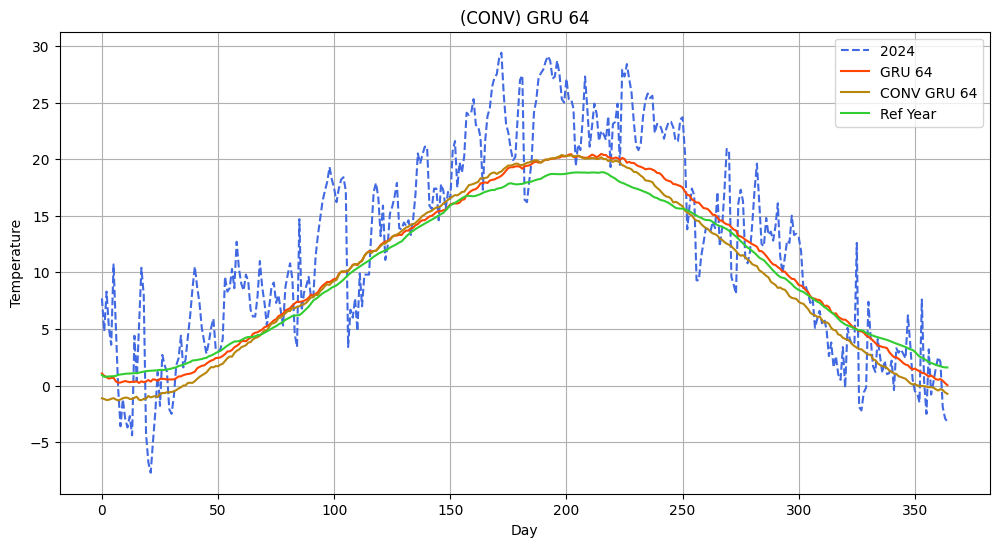

In [106]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_64[:, 2], label="GRU 64", color='orangered')
plt.plot(x, Y_conv_gru_64[:, 2], label="CONV GRU 64", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 64")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [107]:
gru_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_128 = gru_128.fit(train_ds, validation_data=valid_ds, epochs=30)
gru_128.save('models/gru_128.keras')

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 131.1893 - mae: 9.1522 - val_loss: 70.9631 - val_mae: 7.0866
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 70.6627 - mae: 7.0302 - val_loss: 68.5967 - val_mae: 6.9641
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 69.2372 - mae: 6.9469 - val_loss: 66.1595 - val_mae: 6.8242
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 66.3020 - mae: 6.7792 - val_loss: 61.2973 - val_mae: 6.5381
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 60.7072 - mae: 6.4417 - val_loss: 54.2693 - val_mae: 6.0944
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 54.3944 - mae: 6.0416 - val_loss: 49.3399 - val_mae: 5.7720
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 49.8558 - mae: 5.7482 - val_loss: 43.9238 - val_mae: 5.4098
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 43.7836 - mae: 5.3451 - val_loss: 35.7787 - val_mae: 4.8243
Epoch 9/30
183/183 ━━━━━━━━━━━━

In [108]:
gru_128 = tf.keras.models.load_model('models/gru_128.keras')

Y_gru_128 = gru_128.predict(X)  # shape: (1, 365, 3)
Y_gru_128 = Y_gru_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_128_pred.csv')

mae_gru_128 = mean_absolute_error(Y_test[:, 2], Y_gru_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_128:.3f}')

rmse_gru_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Mean Absolute Error (MAE): 3.620
Root Mean Squared Error (RMSE): 4.456


In [113]:
conv_gru_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_128 = conv_gru_128.fit(train_ds, validation_data=valid_ds, epochs=30)
conv_gru_128.save('models/conv_gru_128.keras')

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 131.3339 - mae: 9.1604 - val_loss: 72.4758 - val_mae: 7.1685
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 72.5062 - mae: 7.1295 - val_loss: 71.4365 - val_mae: 7.1200
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 72.4426 - mae: 7.1233 - val_loss: 71.4571 - val_mae: 7.1209
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 72.3593 - mae: 7.1180 - val_loss: 71.4538 - val_mae: 7.1198
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 71.8537 - mae: 7.0900 - val_loss: 68.6448 - val_mae: 6.9623
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 68.4167 - mae: 6.8944 - val_loss: 63.0940 - val_mae: 6.6422
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 63.3762 - mae: 6.6002 - val_loss: 58.9379 - val_mae: 6.3930
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 58.6724 - mae: 6.3175 - val_loss: 51.7975 - val_mae: 5.9375
Epoch 9/30
183/183 ━━━━━━━━━━━━

In [114]:
conv_gru_128 = tf.keras.models.load_model('models/conv_gru_128.keras')

Y_conv_gru_128 = conv_gru_128.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_128 = Y_conv_gru_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_128_pred.csv')

mae_conv_gru_128 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_128:.3f}')

rmse_conv_gru_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Mean Absolute Error (MAE): 3.789
Root Mean Squared Error (RMSE): 4.662


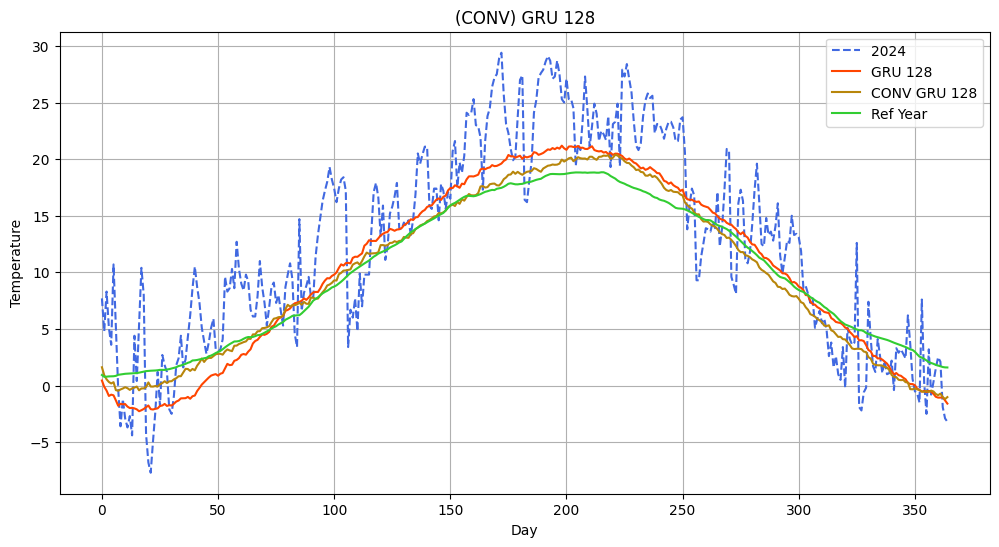

In [115]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_128[:, 2], label="GRU 128", color='orangered')
plt.plot(x, Y_conv_gru_128[:, 2], label="CONV GRU 128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [116]:
gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_3232 = gru_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
gru_3232.save('models/gru_3232.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 168.6964 - mae: 10.4183 - val_loss: 121.0907 - val_mae: 8.8220
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 102.1492 - mae: 8.2061 - val_loss: 87.7148 - val_mae: 7.7224
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 80.8324 - mae: 7.4655 - val_loss: 76.2395 - val_mae: 7.3100
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 74.2402 - mae: 7.2109 - val_loss: 72.6948 - val_mae: 7.1777
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 72.6465 - mae: 7.1402 - val_loss: 71.7150 - val_mae: 7.1352
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 72.3381 - mae: 7.1223 - val_loss: 71.4387 - val_mae: 7.1212
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 72.3440 - mae: 7.1193 - val_loss: 71.3628 - val_mae: 7.1170
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 72.2755 - mae: 7.1145 - val_loss: 71.3381 - val_mae: 7.1157
Epoch 9/60
183/183 ━━━━━━━━

In [117]:
gru_3232 = tf.keras.models.load_model('models/gru_3232.keras')

Y_gru_3232 = gru_3232.predict(X)  # shape: (1, 365, 3)
Y_gru_3232 = Y_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_3232_pred.csv')

mae_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_3232:.3f}')

rmse_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Mean Absolute Error (MAE): 3.672
Root Mean Squared Error (RMSE): 4.425


In [7]:
conv_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_3232.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_3232 = conv_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_gru_3232.save('models/conv_gru_3232.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 168.6667 - mae: 10.4156 - val_loss: 121.9443 - val_mae: 8.8493
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 102.7868 - mae: 8.2276 - val_loss: 88.2379 - val_mae: 7.7407
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 81.1075 - mae: 7.4751 - val_loss: 76.4525 - val_mae: 7.3177
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 74.4277 - mae: 7.2183 - val_loss: 72.7791 - val_mae: 7.1809
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 72.7046 - mae: 7.1447 - val_loss: 71.7321 - val_mae: 7.1363
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 72.3207 - mae: 7.1218 - val_loss: 71.4407 - val_mae: 7.1214
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 72.2822 - mae: 7.1156 - val_loss: 71.3633 - val_mae: 7.1172
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 72.2907 - mae: 7.1153 - val_loss: 71.3331 - val_mae: 7.1155
Epoch 9/40
183/183 ━━━━━━━━━

In [8]:
from tensorflow.keras.models import load_model
conv_gru_3232 = load_model('models/conv_gru_3232.keras')
history_conv_gru_3232_2 = conv_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_3232.save('models/conv_gru_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 17.6011 - mae: 3.1896 - val_loss: 15.9609 - val_mae: 3.0194
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 17.3609 - mae: 3.1615 - val_loss: 15.5116 - val_mae: 2.9804
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 17.2203 - mae: 3.1439 - val_loss: 15.9327 - val_mae: 3.0259
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 17.2069 - mae: 3.1427 - val_loss: 15.5784 - val_mae: 2.9900
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 17.1310 - mae: 3.1344 - val_loss: 15.8168 - val_mae: 3.0202
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 17.0726 - mae: 3.1278 - val_loss: 15.9767 - val_mae: 3.0353
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 17.0161 - mae: 3.1212 - val_loss: 16.2266 - val_mae: 3.0568
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 17.0113 - mae: 3.1213 - val_loss: 16.2847 - val_mae: 3.0651
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [9]:
conv_gru_3232 = tf.keras.models.load_model('models/conv_gru_3232.keras')

Y_conv_gru_3232 = conv_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_3232 = Y_conv_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_3232_pred.csv')

mae_conv_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_3232:.3f}')

rmse_conv_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
Mean Absolute Error (MAE): 3.496
Root Mean Squared Error (RMSE): 4.323


In [11]:
gru_3232 = tf.keras.models.load_model('models/gru_3232.keras')

Y_gru_3232 = gru_3232.predict(X)  # shape: (1, 365, 3)
Y_gru_3232 = Y_gru_3232[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


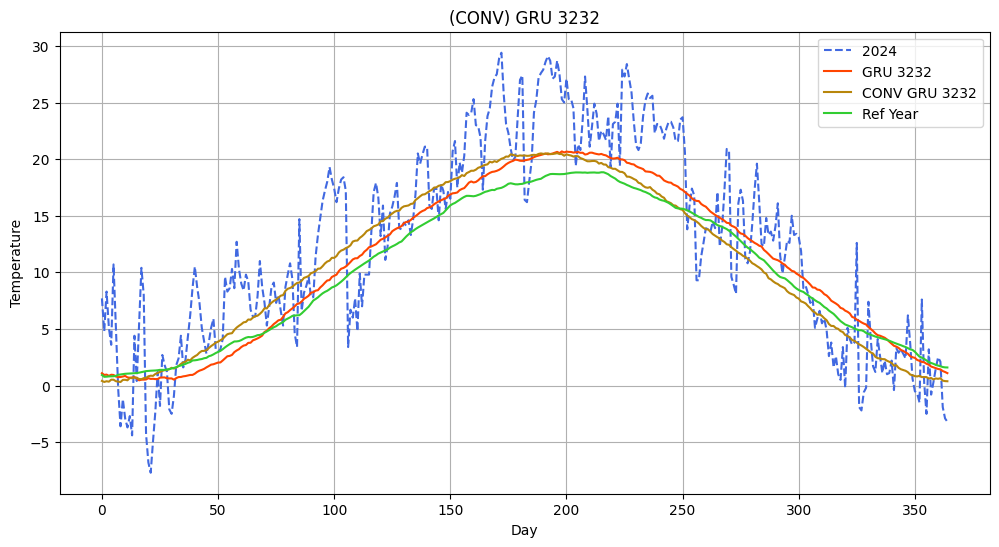

In [12]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_3232[:, 2], label="GRU 3232", color='orangered')
plt.plot(x, Y_conv_gru_3232[:, 2], label="CONV GRU 3232", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [13]:
gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_6464 = gru_6464.fit(train_ds, validation_data=valid_ds, epochs=40)
gru_6464.save('models/gru_6464.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 151.4868 - mae: 9.8438 - val_loss: 87.0994 - val_mae: 7.7004
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 78.7535 - mae: 7.3843 - val_loss: 72.6370 - val_mae: 7.1752
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 72.6193 - mae: 7.1377 - val_loss: 71.4660 - val_mae: 7.1224
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 72.3375 - mae: 7.1185 - val_loss: 71.3703 - val_mae: 7.1172
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 72.2974 - mae: 7.1155 - val_loss: 71.3635 - val_mae: 7.1168
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 72.3977 - mae: 7.1209 - val_loss: 71.3383 - val_mae: 7.1159
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 72.2537 - mae: 7.1143 - val_loss: 71.3585 - val_mae: 7.1167
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 72.2818 - mae: 7.1149 - val_loss: 71.3626 - val_mae: 7.1168
Epoch 9/40
183/183 ━━━━━━━━━

In [15]:
from tensorflow.keras.models import load_model
gru_6464 = load_model('models/gru_6464.keras')
history_gru_6464_2 = gru_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_6464.save('models/gru_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 16.3382 - mae: 3.0514 - val_loss: 15.4755 - val_mae: 2.9421
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 16.3077 - mae: 3.0489 - val_loss: 15.5384 - val_mae: 2.9493
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 16.2487 - mae: 3.0425 - val_loss: 15.5526 - val_mae: 2.9513
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 16.2137 - mae: 3.0397 - val_loss: 15.5090 - val_mae: 2.9470
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 16.1704 - mae: 3.0356 - val_loss: 15.8028 - val_mae: 2.9836
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 16.1479 - mae: 3.0336 - val_loss: 15.4624 - val_mae: 2.9363
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 16.1240 - mae: 3.0325 - val_loss: 15.6847 - val_mae: 2.9668
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 16.1283 - mae: 3.0332 - val_loss: 15.8681 - val_mae: 2.9864
Epoch 9/10
183/183 ━━━━━━━━━

In [16]:
gru_6464 = tf.keras.models.load_model('models/gru_6464.keras')

Y_gru_6464 = gru_6464.predict(X)  # shape: (1, 365, 3)
Y_gru_6464 = Y_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_6464_pred.csv')

mae_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_6464:.3f}')

rmse_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Mean Absolute Error (MAE): 3.813
Root Mean Squared Error (RMSE): 4.663


In [17]:
conv_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_6464.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_6464 = conv_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_gru_6464.save('models/conv_gru_6464.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 151.6969 - mae: 9.8511 - val_loss: 88.0278 - val_mae: 7.7328
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 79.2140 - mae: 7.4023 - val_loss: 72.7840 - val_mae: 7.1811
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 72.6313 - mae: 7.1382 - val_loss: 71.4627 - val_mae: 7.1225
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 72.3052 - mae: 7.1177 - val_loss: 71.3628 - val_mae: 7.1170
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 72.3227 - mae: 7.1170 - val_loss: 71.3382 - val_mae: 7.1158
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 72.3431 - mae: 7.1176 - val_loss: 71.3225 - val_mae: 7.1154
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 72.3558 - mae: 7.1176 - val_loss: 71.3432 - val_mae: 7.1162
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 72.3522 - mae: 7.1182 - val_loss: 71.3491 - val_mae: 7.1161
Epoch 9/40
183/183 ━━━━━━━━━━━━

In [18]:
conv_gru_6464 = tf.keras.models.load_model('models/conv_gru_6464.keras')

Y_conv_gru_6464 = conv_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_6464 = Y_conv_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_6464_pred.csv')

mae_conv_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_6464:.3f}')

rmse_conv_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
Mean Absolute Error (MAE): 3.763
Root Mean Squared Error (RMSE): 4.638


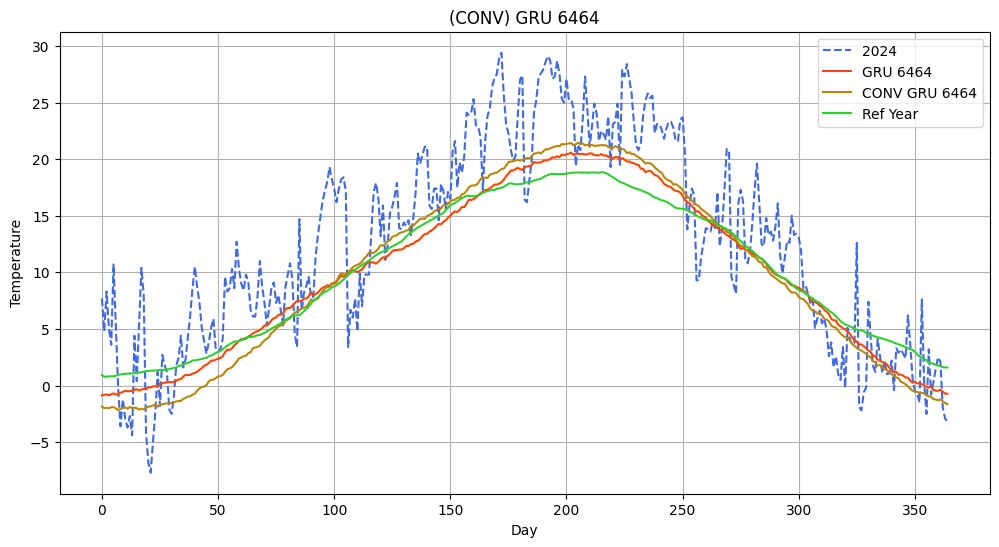

In [19]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_6464[:, 2], label="GRU 6464", color='orangered')
plt.plot(x, Y_conv_gru_6464[:, 2], label="CONV GRU 6464", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [24]:
gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_128128 = gru_128128.fit(train_ds, validation_data=valid_ds, epochs=20)
gru_128128.save('models/gru_128128.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - loss: 130.6582 - mae: 9.1419 - val_loss: 72.2986 - val_mae: 7.1614
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 72.3801 - mae: 7.1242 - val_loss: 71.3833 - val_mae: 7.1175
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 72.4308 - mae: 7.1217 - val_loss: 71.4316 - val_mae: 7.1193
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 72.3945 - mae: 7.1203 - val_loss: 70.3787 - val_mae: 7.0587
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 70.0344 - mae: 6.9867 - val_loss: 65.9499 - val_mae: 6.8106
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 66.2392 - mae: 6.7710 - val_loss: 63.0306 - val_mae: 6.6404
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 63.0746 - mae: 6.5881 - val_loss: 57.9674 - val_mae: 6.3317
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 57.2129 - mae: 6.2288 - val_loss: 50.8621 - val_mae: 5.8722
Epoch 9/20
183/183 ━━━━━━━━━━━

In [15]:
from tensorflow.keras.models import load_model
gru_128128 = load_model('models/gru_128128.keras')
history_gru_128128_2 = gru_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_128128.save('models/gru_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 16.4884 - mae: 3.0684 - val_loss: 16.1579 - val_mae: 3.0274
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 16.3943 - mae: 3.0583 - val_loss: 16.4695 - val_mae: 3.0622
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 16.3296 - mae: 3.0523 - val_loss: 16.5773 - val_mae: 3.0769
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 16.2484 - mae: 3.0433 - val_loss: 16.5797 - val_mae: 3.0794
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 16.2797 - mae: 3.0496 - val_loss: 16.5528 - val_mae: 3.0764
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 16.0959 - mae: 3.0292 - val_loss: 16.6263 - val_mae: 3.0949
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 16.0735 - mae: 3.0282 - val_loss: 16.4006 - val_mae: 3.0741
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 15.9978 - mae: 3.0214 - val_loss: 16.4544 - val_mae: 3.0642
Epoch 9/10
183/183 ━━━━━━━

In [16]:
gru_128128 = tf.keras.models.load_model('models/gru_128128.keras')

Y_gru_128128 = gru_128128.predict(X)  # shape: (1, 365, 3)
Y_gru_128128 = Y_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_128128_pred.csv')

mae_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_128128:.3f}')

rmse_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Mean Absolute Error (MAE): 3.672
Root Mean Squared Error (RMSE): 4.528


In [26]:
conv_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_128128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_128128 = conv_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=20)
conv_gru_128128.save('models/conv_gru_128128.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 131.1635 - mae: 9.1576 - val_loss: 72.4388 - val_mae: 7.1672
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 72.5029 - mae: 7.1300 - val_loss: 71.4289 - val_mae: 7.1196
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 72.3883 - mae: 7.1200 - val_loss: 71.4289 - val_mae: 7.1192
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 72.3912 - mae: 7.1200 - val_loss: 71.3646 - val_mae: 7.1167
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 72.2543 - mae: 7.1136 - val_loss: 69.8233 - val_mae: 7.0299
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 70.0867 - mae: 6.9914 - val_loss: 65.2303 - val_mae: 6.7675
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 64.1985 - mae: 6.6504 - val_loss: 56.3056 - val_mae: 6.2208
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 55.0140 - mae: 6.0856 - val_loss: 45.7773 - val_mae: 5.5349
Epoch 9/20
183/183 ━━━━━━━━━━━━

In [28]:
from tensorflow.keras.models import load_model
conv_gru_128128 = load_model('models/conv_gru_128128.keras')
history_conv_gru_128128_2 = conv_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_128128.save('models/conv_gru_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 16.2081 - mae: 3.0390 - val_loss: 15.7765 - val_mae: 2.9972
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 16.1585 - mae: 3.0357 - val_loss: 15.7287 - val_mae: 2.9801
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 16.0197 - mae: 3.0205 - val_loss: 15.8948 - val_mae: 3.0046
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 15.9974 - mae: 3.0213 - val_loss: 15.7775 - val_mae: 2.9937
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 15.8736 - mae: 3.0073 - val_loss: 15.7708 - val_mae: 3.0082
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 15.8005 - mae: 3.0012 - val_loss: 15.8640 - val_mae: 3.0034
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 15.7139 - mae: 2.9945 - val_loss: 15.9363 - val_mae: 3.0225
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 15.6273 - mae: 2.9862 - val_loss: 16.1890 - val_mae: 3.0679
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [29]:
conv_gru_128128 = tf.keras.models.load_model('models/conv_gru_128128.keras')

Y_conv_gru_128128 = conv_gru_128128.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_128128 = Y_conv_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_128128_pred.csv')

mae_conv_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_128128:.3f}')

rmse_conv_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Mean Absolute Error (MAE): 3.643
Root Mean Squared Error (RMSE): 4.500


In [17]:
conv_gru_128128 = tf.keras.models.load_model('models/conv_gru_128128.keras')

Y_conv_gru_128128 = conv_gru_128128.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_128128 = Y_conv_gru_128128[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


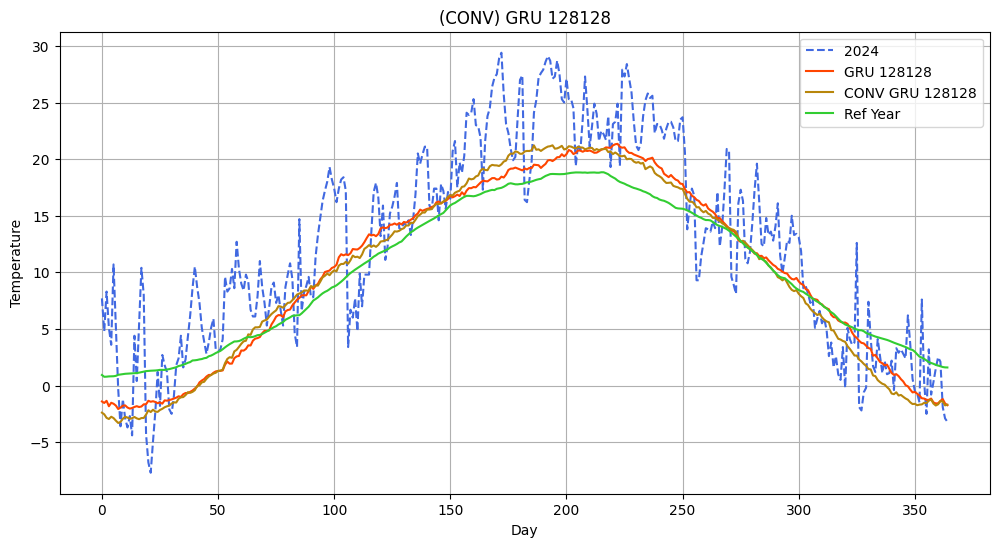

In [18]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_128128[:, 2], label="GRU 128128", color='orangered')
plt.plot(x, Y_conv_gru_128128[:, 2], label="CONV GRU 128128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [31]:
lstm_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_3232 = lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_gru_3232.save('models/lstm_gru_3232.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 169.0506 - mae: 10.4289 - val_loss: 119.0455 - val_mae: 8.7556
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 100.6609 - mae: 8.1544 - val_loss: 86.5829 - val_mae: 7.6822
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 80.1323 - mae: 7.4395 - val_loss: 75.7752 - val_mae: 7.2933
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 74.0272 - mae: 7.2017 - val_loss: 72.5397 - val_mae: 7.1714
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 72.5288 - mae: 7.1353 - val_loss: 71.6635 - val_mae: 7.1328
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 72.2947 - mae: 7.1182 - val_loss: 71.4196 - val_mae: 7.1202
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 72.2776 - mae: 7.1161 - val_loss: 71.3501 - val_mae: 7.1165
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 72.3415 - mae: 7.1181 - val_loss: 71.3324 - val_mae: 7.1155
Epoch 9/60
183/183 ━━━━━━━━

In [33]:
from tensorflow.keras.models import load_model
lstm_gru_3232 = load_model('models/lstm_gru_3232.keras')
history_lstm_gru_3232_2 = lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_gru_3232.save('models/lstm_gru_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 16.8315 - mae: 3.1054 - val_loss: 15.7130 - val_mae: 3.0315
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 16.7524 - mae: 3.0953 - val_loss: 15.8864 - val_mae: 3.0386
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 16.7368 - mae: 3.0950 - val_loss: 15.8084 - val_mae: 3.0326
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 16.7271 - mae: 3.0941 - val_loss: 16.0429 - val_mae: 3.0649
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 16.7028 - mae: 3.0913 - val_loss: 15.9286 - val_mae: 3.0287
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 16.6525 - mae: 3.0857 - val_loss: 15.9726 - val_mae: 3.0374
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 16.6326 - mae: 3.0834 - val_loss: 15.9846 - val_mae: 3.0488
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 16.6161 - mae: 3.0817 - val_loss: 15.9799 - val_mae: 3.0462
Epoch 9/10
183/183 ━━━━━━━━━━

In [34]:
lstm_gru_3232 = tf.keras.models.load_model('models/lstm_gru_3232.keras')

Y_lstm_gru_3232 = lstm_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_3232 = Y_lstm_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_gru_3232_pred.csv')

mae_lstm_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_lstm_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_3232:.3f}')

rmse_lstm_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Mean Absolute Error (MAE): 3.832
Root Mean Squared Error (RMSE): 4.683


In [35]:
conv_lstm_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_3232 = conv_lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=50)
conv_lstm_gru_3232.save('models/conv_lstm_gru_3232.keras')

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 168.9491 - mae: 10.4247 - val_loss: 120.6459 - val_mae: 8.8072
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 101.8009 - mae: 8.1941 - val_loss: 87.4747 - val_mae: 7.7137
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 80.6596 - mae: 7.4592 - val_loss: 76.1569 - val_mae: 7.3070
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 74.2513 - mae: 7.2119 - val_loss: 72.6757 - val_mae: 7.1768
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 72.6333 - mae: 7.1382 - val_loss: 71.7021 - val_mae: 7.1346
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 72.3039 - mae: 7.1196 - val_loss: 71.4372 - val_mae: 7.1210
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 72.3333 - mae: 7.1177 - val_loss: 71.3562 - val_mae: 7.1168
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 72.2589 - mae: 7.1142 - val_loss: 71.3427 - val_mae: 7.1159
Epoch 9/50
183/183 ━━━━━━━━━

In [36]:
conv_lstm_gru_3232 = tf.keras.models.load_model('models/conv_lstm_gru_3232.keras')

Y_conv_lstm_gru_3232 = conv_lstm_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_gru_3232 = Y_conv_lstm_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_gru_3232_pred.csv')

mae_conv_lstm_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_3232:.3f}')

rmse_conv_lstm_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Mean Absolute Error (MAE): 3.703
Root Mean Squared Error (RMSE): 4.542


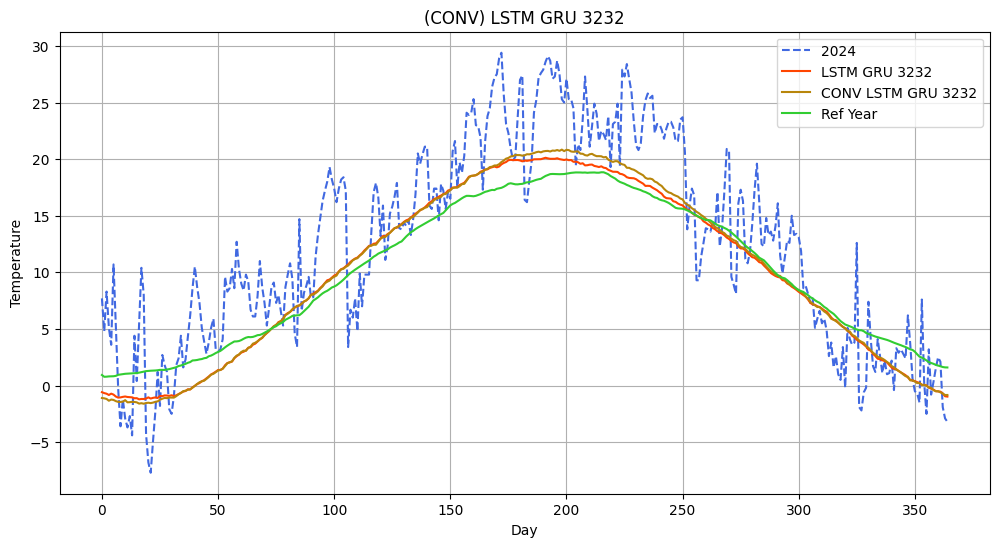

In [37]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_3232[:, 2], label="LSTM GRU 3232", color='orangered')
plt.plot(x, Y_conv_lstm_gru_3232[:, 2], label="CONV LSTM GRU 3232", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM GRU 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [38]:
lstm_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_6464= lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=40)
lstm_gru_6464.save('models/lstm_gru_6464.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 151.8472 - mae: 9.8516 - val_loss: 85.4913 - val_mae: 7.6200
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 76.8428 - mae: 7.2825 - val_loss: 69.5748 - val_mae: 7.0083
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 69.2345 - mae: 6.9531 - val_loss: 67.0939 - val_mae: 6.8826
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 67.6500 - mae: 6.8615 - val_loss: 65.7288 - val_mae: 6.8072
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 66.5455 - mae: 6.7966 - val_loss: 64.6019 - val_mae: 6.7420
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 65.3663 - mae: 6.7299 - val_loss: 63.4443 - val_mae: 6.6759
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 64.2814 - mae: 6.6672 - val_loss: 62.3966 - val_mae: 6.6146
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 63.1321 - mae: 6.6017 - val_loss: 59.5652 - val_mae: 6.4420
Epoch 9/40
183/183 ━━━━━━━━━━━━

In [39]:
lstm_gru_6464 = tf.keras.models.load_model('models/lstm_gru_6464.keras')

Y_lstm_gru_6464 = lstm_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_6464 = Y_lstm_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_gru_6464_pred.csv')

mae_lstm_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_lstm_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_6464:.3f}')

rmse_lstm_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Mean Absolute Error (MAE): 3.599
Root Mean Squared Error (RMSE): 4.430


In [40]:
conv_lstm_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_6464 = conv_lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=30)
conv_lstm_gru_6464.save('models/conv_lstm_gru_6464.keras')

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 151.8515 - mae: 9.8549 - val_loss: 87.4130 - val_mae: 7.7114
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 78.9052 - mae: 7.3902 - val_loss: 72.6797 - val_mae: 7.1771
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 72.5855 - mae: 7.1366 - val_loss: 71.4395 - val_mae: 7.1213
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 72.3488 - mae: 7.1199 - val_loss: 71.3657 - val_mae: 7.1170
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 72.2756 - mae: 7.1148 - val_loss: 71.3487 - val_mae: 7.1163
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 72.3901 - mae: 7.1191 - val_loss: 71.3688 - val_mae: 7.1171
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 72.3550 - mae: 7.1183 - val_loss: 71.3452 - val_mae: 7.1161
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 72.2927 - mae: 7.1154 - val_loss: 71.3576 - val_mae: 7.1166
Epoch 9/30
183/183 ━━━━━━━━━━━━

In [41]:
from tensorflow.keras.models import load_model
conv_lstm_gru_6464 = load_model('models/conv_lstm_gru_6464.keras')
history_conv_lstm_gru_6464_2 = conv_lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_gru_6464.save('models/conv_lstm_gru_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 17.0622 - mae: 3.1241 - val_loss: 15.0301 - val_mae: 2.9210
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 16.9437 - mae: 3.1124 - val_loss: 15.9807 - val_mae: 3.0306
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 16.8657 - mae: 3.1055 - val_loss: 15.3537 - val_mae: 2.9522
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 16.7512 - mae: 3.0927 - val_loss: 15.5332 - val_mae: 2.9697
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 16.6946 - mae: 3.0869 - val_loss: 16.0147 - val_mae: 3.0202
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 16.5775 - mae: 3.0740 - val_loss: 15.8062 - val_mae: 2.9944
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 16.5404 - mae: 3.0707 - val_loss: 16.0156 - val_mae: 3.0150
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 16.5174 - mae: 3.0692 - val_loss: 15.9589 - val_mae: 3.0074
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [42]:
conv_lstm_gru_6464 = tf.keras.models.load_model('models/conv_lstm_gru_6464.keras')

Y_conv_lstm_gru_6464 = conv_lstm_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_gru_6464 = Y_conv_lstm_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_gru_6464_pred.csv')

mae_conv_lstm_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_6464:.3f}')

rmse_conv_lstm_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Mean Absolute Error (MAE): 3.736
Root Mean Squared Error (RMSE): 4.570


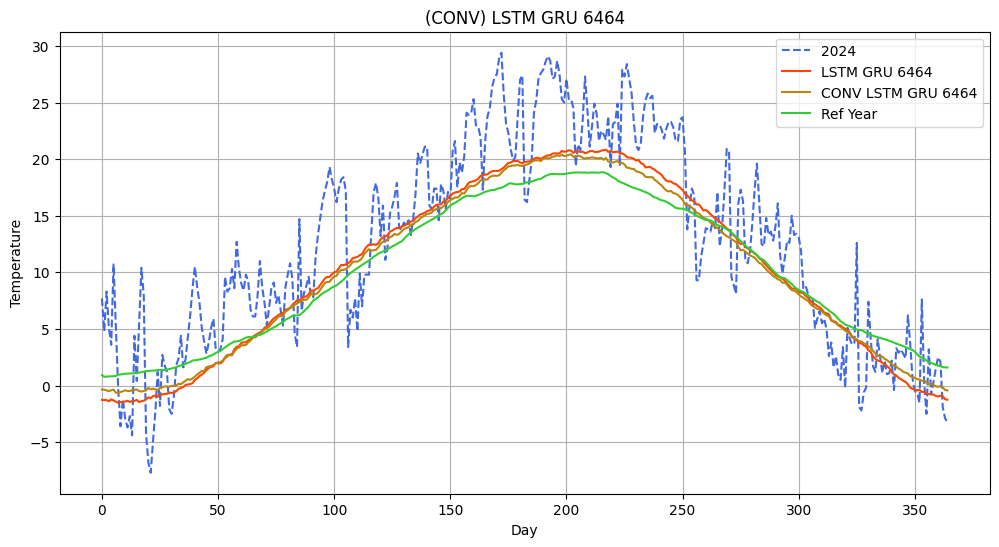

In [43]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_6464[:, 2], label="LSTM GRU 6464", color='orangered')
plt.plot(x, Y_conv_lstm_gru_6464[:, 2], label="CONV LSTM GRU 6464", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM GRU 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [44]:
lstm_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_128128= lstm_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=30)
lstm_gru_128128.save('models/lstm_gru_128128.keras')

Epoch 1/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 130.9483 - mae: 9.1509 - val_loss: 72.2755 - val_mae: 7.1602
Epoch 2/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 72.4568 - mae: 7.1276 - val_loss: 71.3983 - val_mae: 7.1183
Epoch 3/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 72.3621 - mae: 7.1185 - val_loss: 71.3966 - val_mae: 7.1184
Epoch 4/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 72.3609 - mae: 7.1183 - val_loss: 71.4591 - val_mae: 7.1202
Epoch 5/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 72.3677 - mae: 7.1189 - val_loss: 71.4423 - val_mae: 7.1197
Epoch 6/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 71.9674 - mae: 7.0957 - val_loss: 69.0761 - val_mae: 6.9885
Epoch 7/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 69.6091 - mae: 6.9648 - val_loss: 66.3624 - val_mae: 6.8331
Epoch 8/30
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 66.2564 - mae: 6.7738 - val_loss: 60.3239 - val_mae: 6.4766
Epoch 9/30
183/183 ━━━━━━━━━━━

In [45]:
lstm_gru_128128 = tf.keras.models.load_model('models/lstm_gru_128128.keras')

Y_lstm_gru_128128 = lstm_gru_128128.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_128128 = Y_lstm_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_gru_128128_pred.csv')

mae_lstm_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_lstm_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_128128:.3f}')

rmse_lstm_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Mean Absolute Error (MAE): 3.790
Root Mean Squared Error (RMSE): 4.640


In [21]:
conv_lstm_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_128128 = conv_lstm_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=20)
conv_lstm_gru_128128.save('models/conv_lstm_gru_128128.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 131.6379 - mae: 9.1723 - val_loss: 72.3926 - val_mae: 7.1651
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 72.4765 - mae: 7.1297 - val_loss: 71.3821 - val_mae: 7.1175
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 72.3345 - mae: 7.1178 - val_loss: 71.3678 - val_mae: 7.1168
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 72.3456 - mae: 7.1176 - val_loss: 71.4473 - val_mae: 7.1196
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 72.4107 - mae: 7.1204 - val_loss: 71.4485 - val_mae: 7.1196
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 71.8698 - mae: 7.0910 - val_loss: 67.6647 - val_mae: 6.9047
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 66.2291 - mae: 6.7697 - val_loss: 58.3745 - val_mae: 6.3598
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 56.7349 - mae: 6.1959 - val_loss: 44.7954 - val_mae: 5.4714
Epoch 9/20
183/183 ━━━━━━━━━━━━

In [22]:
conv_lstm_gru_128128 = tf.keras.models.load_model('models/conv_lstm_gru_128128.keras')

Y_conv_lstm_gru_128128 = conv_lstm_gru_128128.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_gru_128128 = Y_conv_lstm_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_gru_128128_pred.csv')

mae_conv_lstm_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_128128:.3f}')

rmse_conv_lstm_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Mean Absolute Error (MAE): 3.505
Root Mean Squared Error (RMSE): 4.314


In [24]:
lstm_gru_128128 = tf.keras.models.load_model('models/lstm_gru_128128.keras')

Y_lstm_gru_128128 = lstm_gru_128128.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_128128 = Y_lstm_gru_128128[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


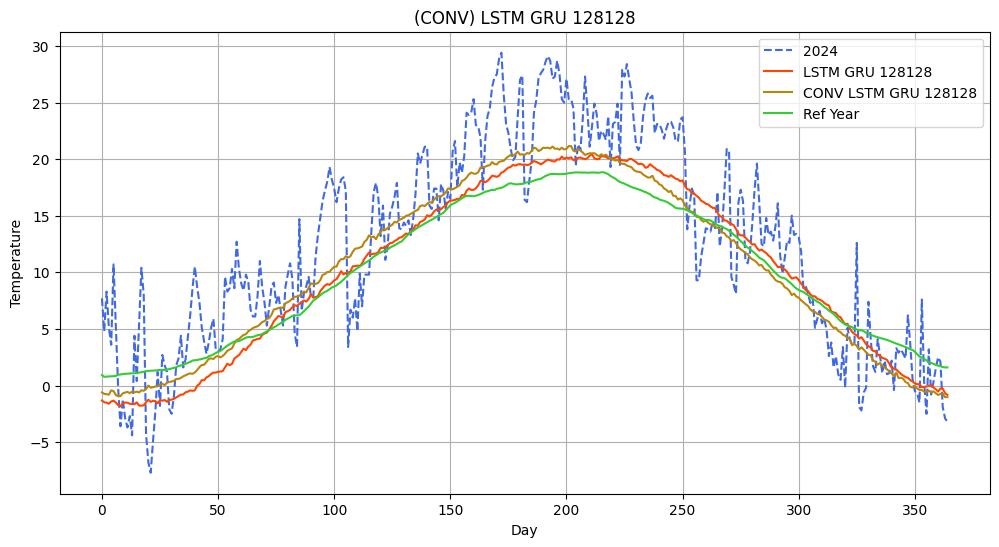

In [25]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_128128[:, 2], label="LSTM GRU 128128", color='orangered')
plt.plot(x, Y_conv_lstm_gru_128128[:, 2], label="CONV LSTM GRU 128128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM GRU 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 